# Molecular Dynamics

Atomic simulation using the Morse potential:

https://en.wikipedia.org/wiki/Morse_potential


<img src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Morse-potential.png" alt="Drawing" style="width: 500px;"/>
*source: https://en.wikipedia.org/wiki/Morse_potential*



<div class="alert alert-block alert-info">
PMD module available here: [PMD.py](./PMD.py)
</div>

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate, optimize, spatial
from matplotlib import animation, rc
import sympy as sp
from PMD import PMD, distances, MetaForce
sp.init_printing(use_latex = "mathjax")
rc('animation', html='html5')
%matplotlib nbagg

## Potential

In [3]:
De, a, re, r = sp.symbols("D_e a r_e r")
V = De * ((1- sp.exp(-a * (r-re)))**2 -1)
V

   ⎛                  2    ⎞
   ⎜⎛     -a⋅(r - rₑ)⎞     ⎟
Dₑ⋅⎝⎝1 - ℯ           ⎠  - 1⎠

## Force

In [4]:
F = -V.diff(r).simplify()
F

        ⎛ a⋅(r - rₑ)    ⎞  -2⋅a⋅(r - rₑ)
-2⋅Dₑ⋅a⋅⎝ℯ           - 1⎠⋅ℯ             

## Plotting

<IPython.core.display.Javascript object>


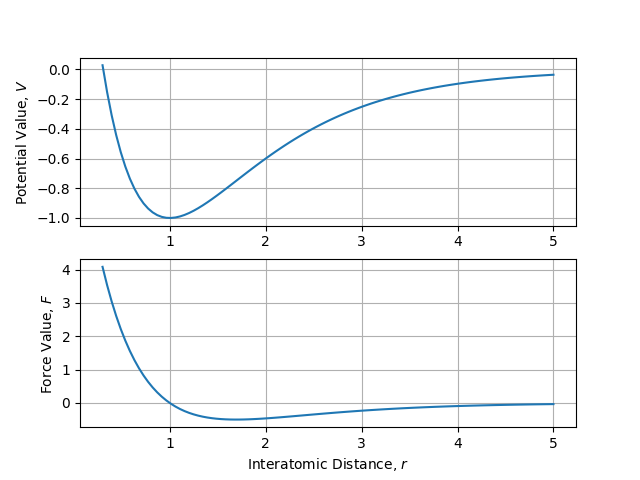

In [5]:
values = {De:1., a:1., re:1}
Vf = sp.lambdify(r, V.subs(values), "numpy")
Ff = sp.lambdify(r, F.subs(values), "numpy")
vr = np.linspace(.3 * values[re], 5 * values[re], 100)
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.plot(vr, Vf(vr))
plt.grid()
plt.ylabel("Potential Value, $V$")
ax = fig.add_subplot(2,1,2)
plt.plot(vr, Ff(vr))
plt.grid()
plt.xlabel("Interatomic Distance, $r$")
plt.ylabel("Force Value, $F$")
plt.show()

In [7]:
class Morse(MetaForce):
    """
    Morse potential force.
    """
    
    def __init__(self, De = 1., a = 1., re = 1., mu = 0.):
        self.De = De
        self.a = a
        self.re = re
        self.mu = mu
    
    
    def force(self, P, V):
        De, a, re, mu = self.De, self.a, self.re, self.mu
        D, R, U = distances(P)
        F = np.where(R[:,:,np.newaxis] != 0.,
             (2. * De * a * ( np.exp( a * (R - re)) -1 ) * np.exp(-2 * a * (R - re)))[:,:,np.newaxis] * U, 
             0.).sum(axis = 0)
        Vx, Vy =  V.T
        F -= V * mu
        return F
    
    
        
     
    

<IPython.core.display.Javascript object>


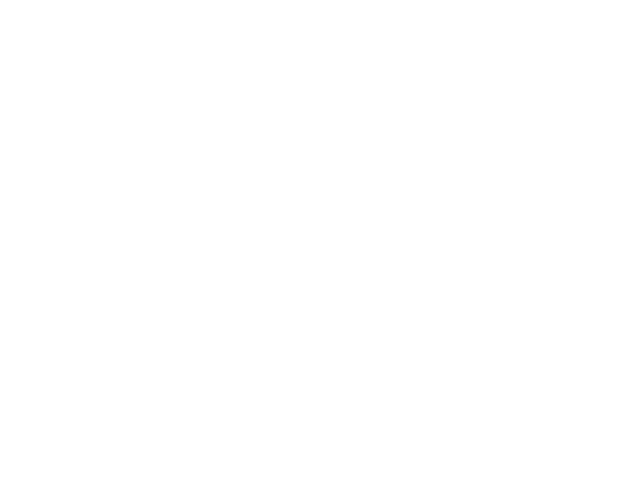

In [11]:
morse = Morse(mu = 10., re = 1., a = 2., De = 1.)

nm = 100
P0 = (np.random.rand(nm, 2) *.5) * morse.re * nm**.5
P0 -= P0.mean(axis = 0)
V0 = np.zeros_like(P0)
pcolors = "r"
tcolors = "k"
m = np.ones(nm)*1.e0



s = PMD(m, P0, V0, force = morse, nk = 5000)      
dt = 0.02
nt = 100
s.solve(dt, nt)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
margin = 1.
plt.xlim(P0[:,0].min() - margin, P0[:,0].max() + margin)
plt.ylim(P0[:,1].min() - margin, P0[:,1].max() + margin)
plt.grid()
#ax.axis("off")
points = []

msize = 10. * (s.m / s.m.max())**(1./6.)
for i in range(nm):
    plc = len(pcolors)
    pc = pcolors[i%plc]
    tlc = len(tcolors)
    tc = tcolors[i%tlc]
    trail, = ax.plot([], [], "-"+tc)
    point, = ax.plot([], [], "o"+pc, markersize = msize[i])
    points.append(point)
    points.append(trail)

    
def init():
    for i in range(2 * nm):
        points[i].set_data([], [])
    return points 

def animate(i):
    s.solve(dt, nt)#, rtol = 1.e-8, atol = 1.e-8)
    x, y = s.xy()
    for i in range(nm):
        points[2*i].set_data(x[i:i+1], y[i:i+1])
        xt, yt = s.trail(i)
        points[2*i+1].set_data(xt, yt)
    return points

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=400, interval=20, blit=True)


plt.close()
anim
#plt.show()